In [1]:
#!/usr/bin/python
import sys
import math
import glob
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#from sympy import Plane, Point3D

import random

# Loading convenient environment
# %pylab
%matplotlib inline

plt.rcParams['figure.figsize']=[20.,10.]

In [2]:
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

In [3]:
# What are the morphology parameters of influence:
#   - shape of flakes: hexagonal, even circle is fine.. > no "hard" angle (bigger than pi/2.), "natural" shape of ideal flakes
#   - size of flakes: 10-15µm
#   - orientation of flakes: based on one angle and one direction (in the plane of the graphene flake),
#                            direction of load, orthogonal direction of load, random uniform, random with spatial correlation
#   - position/dispersion: regularly disperse, non-crossing of flakes or boundaries
#   - weight ratio: 0.08%, 0.16%
#   - number of flakes: weight ratio > total mass of flakes > number=total mass of flakes/mass of a single flake


# Ex: vcell=150.0e-6*50.0e-6*50.0e-6 & mratio=0.16% & lflake=10µm > 31 flakes
#     if lcell=5µm > ncell=3000 ~ 4 cells/flake

In [32]:
# Parameters of graphene flakes
smass_flake = 0.00077
diam_flake = 10.0e-6
mass_flake = smass_flake*diam_flake**2.0/4.0
thick_flake = 1.0e-9

# Orientation of flakes
referential_flake = np.identity(3) # local referential of the flake (xf and yf define the plane of the flake, zf the normal)

In [33]:
# Parameters of epoxy (ideally to be passed as argument)
dens_epoxy = 1000.
size_sample = [50.0e-6, 150.0e-6, 50.0e-6]
vol_sample = size_sample[0]*size_sample[1]*size_sample[2]
mass_epoxy = dens_epoxy*vol_sample

size_cell = [5.0e-6, 5.0e-6, 5.0e-6]
#vol_cell = size_cell[0]*size_cell[1]*size_cell[2]

In [36]:
# Parameters of composite
mass_ratio =0.002
mass_graphene = mass_epoxy*mass_ratio

In [38]:
# Number of flakes in sample
nb_flakes = int(mass_graphene/mass_flake)
print(nb_flakes)

38


In [39]:
# Position of flakes
flakes_data = pd.DataFrame(columns=['cx','cy','cz','diam','nx','ny','nz','thick'])
for n in range(nb_flakes):
    print('Inserting flake #',n,'...')
    ktry=0
    while True:
        ktry+=1
        print('   attempt #',ktry,'...')
        
        tc=pd.Series(index=flakes_data.columns)
        
        # Flake position
        tc['cx']=random.uniform(0.0+diam_flake, size_sample[0]-diam_flake)
        tc['cy']=random.uniform(0.0+diam_flake, size_sample[1]-diam_flake)
        tc['cz']=random.uniform(0.0+diam_flake, size_sample[2]-diam_flake)
        
        # Flake dimension (here diameter)
        tc['diam'] = diam_flake
        
        # Flake thickness
        tc['thick'] = thick_flake
        
        # Flake orientation (normal direction to flake plane)
        tc['nx'] = random.uniform(-1.0,1.0)
        tc['ny'] = random.uniform(-1.0,1.0)
        tc['nz'] = random.uniform(-1.0,1.0)
        nrm = (tc['nx']**2.0+tc['ny']**2.0+tc['nz']**2.0)**0.5
        tc['nx']=tc['nx']/nrm
        tc['ny']=tc['ny']/nrm
        tc['nz']=tc['nz']/nrm
        
        valid_flake = True
        
        # How to check if two flakes with different angles are intersecting?
        for m in range(len(flakes_data.index)):
            cc=flakes_data.iloc[m]
            
            # distance in between centers
            dist=(((tc['cx']-cc['cx'])**2.0+(tc['cy']-cc['cy'])**2.0+(tc['cz']-cc['cz'])**2.0)**0.5)
            
            # if distance between centers below sum of radii, keep checking, 
            # otherwise test next candidate
            if(dist<(tc['diam']/2.0+cc['diam']/2.0)):
                # centers coordinates
                tcc = [tc['cx'],tc['cy'],tc['cz']]
                ccc = [cc['cx'],cc['cy'],cc['cz']]
                
                # normal vectors
                tcn = [tc['nx'],tc['ny'],tc['nz']]
                ccn = [cc['nx'],cc['ny'],cc['nz']]
                
                # normal vector to plan containing normal vectors
                p = np.cross(tcn, ccn)
                
                # Intersection line of 'tc' with plan defined by p
                nAB = np.cross(p, tcn)
                A = -tc['diam']*nAB+tcc
                B = tc['diam']*nAB+tcc
                
                # Intersection line of 'cc' with plan defined by p
                nCD = np.cross(p, ccn)
                C = -cc['diam']*nCD+ccc
                D = cc['diam']*nCD+ccc
                
                # define a referential in plane defined by p and nAB
                p1 = p
                p2 = nAB
                p3 = np.cross(p1, nAB)
                
                # Project A, B, C & D on plane (p2,p3)
                pA = [np.dot(A,p2),np.dot(A,p3)]
                pB = [np.dot(B,p2),np.dot(B,p3)]
                pC = [np.dot(C,p2),np.dot(C,p3)]
                pD = [np.dot(D,p2),np.dot(D,p3)]
                
                # Checking if AB and CD intersect? If so, disks intersect...
                if intersect(pA,pB,pC,pD):
                    valid_flake = False
            
        if (valid_flake == True):
            break
    
    flakes_data = flakes_data.append(tc,ignore_index=True)

Inserting flake # 0 ...
   attempt # 1 ...
Inserting flake # 1 ...
   attempt # 1 ...
Inserting flake # 2 ...
   attempt # 1 ...
Inserting flake # 3 ...
   attempt # 1 ...
Inserting flake # 4 ...
   attempt # 1 ...
Inserting flake # 5 ...
   attempt # 1 ...
Inserting flake # 6 ...
   attempt # 1 ...
   attempt # 2 ...
Inserting flake # 7 ...
   attempt # 1 ...
Inserting flake # 8 ...
   attempt # 1 ...
Inserting flake # 9 ...
   attempt # 1 ...
Inserting flake # 10 ...
   attempt # 1 ...
Inserting flake # 11 ...
   attempt # 1 ...
   attempt # 2 ...
Inserting flake # 12 ...
   attempt # 1 ...
Inserting flake # 13 ...
   attempt # 1 ...
Inserting flake # 14 ...
   attempt # 1 ...
Inserting flake # 15 ...
   attempt # 1 ...
Inserting flake # 16 ...
   attempt # 1 ...
Inserting flake # 17 ...
   attempt # 1 ...
Inserting flake # 18 ...
   attempt # 1 ...
Inserting flake # 19 ...
   attempt # 1 ...
   attempt # 2 ...
   attempt # 3 ...
Inserting flake # 20 ...
   attempt # 1 ...
Inserting 

In [40]:
np.dot(p2,p3)

0.0

In [41]:
flakes_data

,cx,cy,cz,diam,nx,ny,nz,thick
0,0.000032,0.000134,0.000012,0.00001,-0.639697,0.696563,-0.324943,1.000000e-09
1,0.000031,0.000122,0.000021,0.00001,0.585337,0.527608,0.615639,1.000000e-09
2,0.000017,0.000101,0.000012,0.00001,-0.250465,0.293437,0.922585,1.000000e-09
3,0.000016,0.000016,0.000014,0.00001,0.303167,0.263890,0.915670,1.000000e-09
4,0.000028,0.000035,0.000028,0.00001,-0.711549,0.620520,-0.329624,1.000000e-09
5,0.000018,0.000027,0.000019,0.00001,-0.517725,-0.691513,0.503757,1.000000e-09
6,0.000027,0.000135,0.000039,0.00001,-0.812131,-0.562146,-0.156318,1.000000e-09
7,0.000037,0.000083,0.000026,0.00001,0.238751,0.903761,0.355265,1.000000e-09
8,0.000029,0.000089,0.000033,0.00001,-0.525470,-0.488712,-0.696449,1.000000e-09
9,0.000026,0.000097,0.000032,0.00001,0.065043,-0.464006,-0.883441,1.000000e-09


In [42]:
# Offset position of flakes so the sample is centered on the origin
flakes_data['cx'] = flakes_data['cx'] - size_sample[0]/2.
flakes_data['cy'] = flakes_data['cy'] - size_sample[1]/2.
flakes_data['cz'] = flakes_data['cz'] - size_sample[2]/2.

In [43]:
file = open('../build_microcube/flakes_data.csv','w')
file.write(str(len(flakes_data.index))+','+str(len(flakes_data.columns))+'\n')
flakes_data.to_csv(file,header=True,index=False)
file.close()

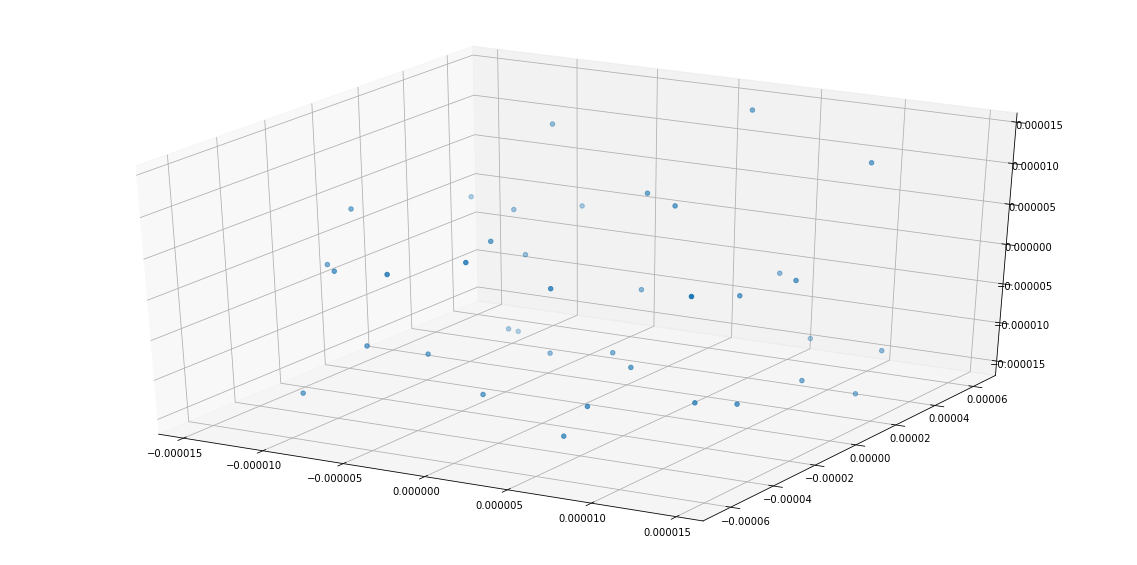

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(flakes_data['cx'],flakes_data['cy'],flakes_data['cz'])
#for m in range(1):

In [45]:
import ipyvolume.pylab as p3
import numpy as np

p3.figure()
s = p3.ipv.quickscatter(flakes_data['cx'],flakes_data['cy'],flakes_data['cz'], size=1, marker="sphere")
# p3.xlim(0., 50e-6)
p3.xyzlim(0., 150e-6)
# p3.zlim(0., 50e-6)
p3.style.use("dark")
p3.show()

VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], scatters=[Scatter(color_selected=array('white',
      dtype='<U5'), geo='sphere', size=array(1), size_selected=array(2.6), x=array([  6.55615090e-06,   5.86529880e-06,  -8.29255989e-06,
        -9.36875920e-06,   3.25646588e-06,  -6.80109447e-06,
         2.26566326e-06,   1.16294981e-05,   3.60840450e-06,
         9.06216709e-07,   6.96864828e-06,   9.07500343e-06,
        -1.36821574e-05,   1.05718574e-05,   1.19196395e-05,
        -9.54058072e-06,   1.44459607e-05,  -9.49213927e-06,
        -1.44691131e-05,  -5.24810610e-06,   1.16343535e-05,
         1.84741773e-06,  -1.29707030e-05,   4.63821529e-07,
         1.28431591e-05,   1.30576843e-05,   2.63949226e-07,
        -4.76089375e-07,  -2.83880826e-06,   1.33841324e-05,
        -3.17253908e-06,  -9.27214354e-06,   5.77869030e-06,
        -1.01136509e-05,  -8.46403269e-06,  -7.71213855e-06,
        -4.17465096e-06,   5.90560797e-06]), y=array([  5.86502731e-05,   4.73610322e-05,   2.59274094e-05,
        -5.86143551e-05,  -3.98920910e-05,  -4.80651837e-05,
         6.04169218e-05,   7.82793308e-06,   1.37578086e-05,
         2.18244517e-05,  -5.15724456e-05,   1.87158333e-06,
        -5.14160297e-06,   5.14257956e-05,   1.04222397e-05,
         5.67046874e-05,  -6.35256292e-05,  -4.20508465e-05,
         5.43829055e-05,  -3.26436911e-05,  -3.85968285e-05,
        -1.04419746e-06,  -2.12777411e-05,   2.29416363e-05,
         4.25764493e-05,  -3.01250508e-05,  -5.45367993e-05,
        -4.29902112e-05,   5.00513727e-06,   2.55366999e-05,
        -6.34470889e-05,   3.76094425e-05,  -2.27494858e-05,
         4.24960955e-05,   6.25715736e-05,   3.00100238e-05,
        -1.15184654e-05,  -5.41998212e-05]), z=array([ -1.34923802e-05,  -3.92648296e-06,  -1.27775189e-05,
        -1.11069348e-05,   3.40652213e-06,  -5.65418497e-06,
         1.39916372e-05,   1.34482076e-06,   7.54592426e-06,
         7.49391952e-06,  -8.49421982e-06,  -5.96701207e-07,
         4.50732938e-06,   1.06433690e-05,  -1.14255246e-05,
         9.65980505e-06,   8.47027367e-06,   2.10212465e-06,
        -5.77881026e-07,  -8.07374164e-06,  -8.20376045e-06,
        -9.56678072e-06,  -4.22604366e-07,  -4.77557402e-06,
        -1.12328330e-05,  -8.98423432e-06,   7.35154265e-06,
        -1.04312492e-05,  -1.17840697e-05,  -1.45491424e-05,
         5.95337539e-06,  -1.47922733e-05,  -7.57862881e-06,
         2.53978871e-07,  -1.01229010e-06,  -3.45958250e-06,
         3.84086486e-06,  -1.22358666e-05]))], style={'axes': {'visible': True, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': True}, 'background-color': 'black'}, tf=None, width=400, xlim=[0.0, 0.00015], ylim=[0.0, 0.00015], zlim=[0.0, 0.00015]),))